<a href="https://colab.research.google.com/github/AREAGAM/upgraded-adventure/blob/main/noise_gray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#!pip3 install git+https://github.com/pvigier/perlin-numpy #上下二选一，删除前面的"#"

In [18]:
import numpy as np


def interpolant(t):
    return t*t*t*(t*(t*6 - 15) + 10)


def generate_perlin_noise_2d(
        shape, res, tileable=(False, False), interpolant=interpolant
):
    """Generate a 2D numpy array of perlin noise.
    Args:
        shape: The shape of the generated array (tuple of two ints).
            This must be a multple of res.
        res: The number of periods of noise to generate along each
            axis (tuple of two ints). Note shape must be a multiple of
            res.
        tileable: If the noise should be tileable along each axis
            (tuple of two bools). Defaults to (False, False).
        interpolant: The interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).
    Returns:
        A numpy array of shape shape with the generated noise.
    Raises:
        ValueError: If shape is not a multiple of res.
    """
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]]\
             .transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    if tileable[0]:
        gradients[-1,:] = gradients[0,:]
    if tileable[1]:
        gradients[:,-1] = gradients[:,0]
    gradients = gradients.repeat(d[0], 0).repeat(d[1], 1)
    g00 = gradients[    :-d[0],    :-d[1]]
    g10 = gradients[d[0]:     ,    :-d[1]]
    g01 = gradients[    :-d[0],d[1]:     ]
    g11 = gradients[d[0]:     ,d[1]:     ]
    # Ramps
    n00 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]  )) * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]  )) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = interpolant(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)


def generate_fractal_noise_2d(
        shape, res, octaves=1, persistence=0.5,
        lacunarity=2, tileable=(False, False),
        interpolant=interpolant
):
    """Generate a 2D numpy array of fractal noise.
    Args:
        shape: The shape of the generated array (tuple of two ints).
            This must be a multiple of lacunarity**(octaves-1)*res.
        res: The number of periods of noise to generate along each
            axis (tuple of two ints). Note shape must be a multiple of
            (lacunarity**(octaves-1)*res).
        octaves: The number of octaves in the noise. Defaults to 1.
        persistence: The scaling factor between two octaves.
        lacunarity: The frequency factor between two octaves.
        tileable: If the noise should be tileable along each axis
            (tuple of two bools). Defaults to (False, False).
        interpolant: The, interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).
    Returns:
        A numpy array of fractal noise and of shape shape generated by
        combining several octaves of perlin noise.
    Raises:
        ValueError: If shape is not a multiple of
            (lacunarity**(octaves-1)*res).
    """
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(
            shape, (frequency*res[0], frequency*res[1]), tileable, interpolant
        )
        frequency *= lacunarity
        amplitude *= persistence
    return noise

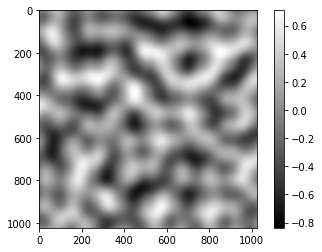

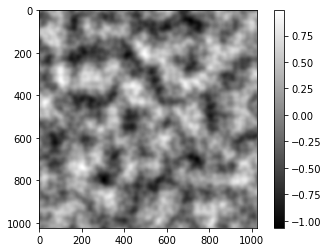

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from perlin_numpy import (
    generate_perlin_noise_2d, generate_fractal_noise_2d
)

np.random.seed(0)
noise = generate_perlin_noise_2d((1024, 1024), (8, 8))
plt.imshow(noise, cmap='gray', interpolation='lanczos')
plt.colorbar()

np.random.seed(0)
noise = generate_fractal_noise_2d((1024, 1024), (8, 8), 3)#这边的3可以调节 越小越光滑
plt.figure()
plt.imshow(noise, cmap='gray', interpolation='lanczos')
plt.colorbar()
plt.show()
    

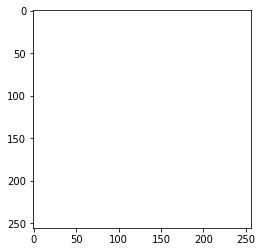

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from perlin_numpy import generate_fractal_noise_3d

np.random.seed(0)
noise = generate_fractal_noise_3d(
    (32, 256, 256), (1, 4, 4), 4, tileable=(True, False, False)
)

fig = plt.figure()
images = [
    [plt.imshow(
        layer, cmap='gray', interpolation='lanczos', animated=True
    )]
    for layer in noise
]
animation_3d = animation.ArtistAnimation(fig, images, interval=50, blit=True)
plt.show()